In [ ]:
 # Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir, compare_historys

--2026-02-12 14:21:17--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-02-12 14:21:18 (126 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/gdrive/MyDrive/archive.zip','r')
zip_ref.extractall('content/dataset')
zip_ref.close()

In [ ]:
train_dir = '/content/content/dataset/train'
val_dir = '/content/content/dataset/valid'
test_dir = '/content/content/dataset/test'

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(42)

BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 label_mode='int',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,

                                                                 )
val_data = tf.keras.preprocessing.image_dataset_from_directory(directory=val_dir,
                                                                 label_mode='int',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,


                                                                 )
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 label_mode='int',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,
                                                                 shuffle=False
                                                                 )


Found 12594 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [ ]:
checkpoint_path ='butterfly_and_moth_100_species_model_checkpoint/checkpoint.weights.h5'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_loss',# save the model weights which score the best validation loss
                                                         save_weights_only=True,
                                                         save_best_only=True
                                                         )
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3)
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [ ]:
from tensorflow import keras

data_augmentation = keras.Sequential([
    keras.layers.RandomFlip(mode='horizontal_and_vertical'),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1)
])

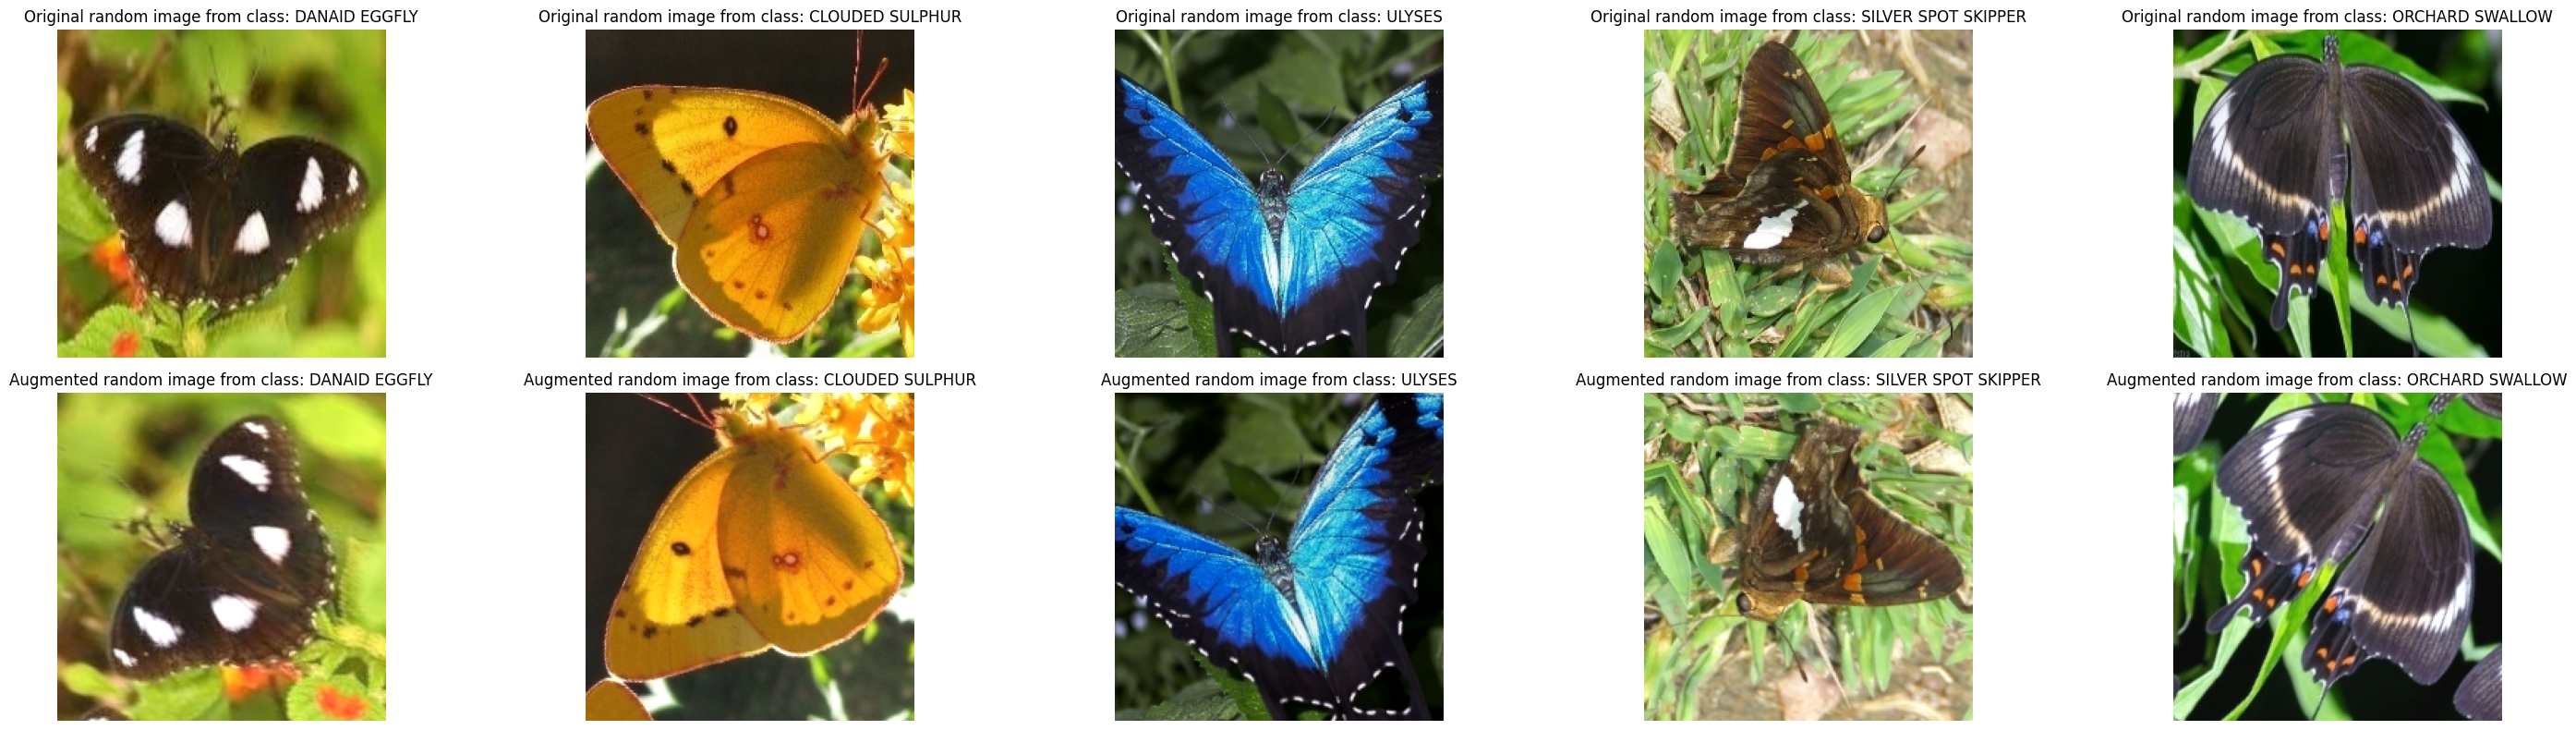

In [ ]:
# Lay duong dan 1 anh bat ki
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

# target_class = random.choice(train_data.class_names)
# target_dir = "/content/content/dataset/train/" + target_class

plt.figure(figsize=(30, 8))

for i in range(5):
  # Original image
  target_class = random.choice(train_data.class_names)
  target_dir = "/content/content/dataset/train/" + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = os.path.join(target_dir, random_image)

  img = mpimg.imread(random_image_path)
  ax = plt.subplot(2, 5, i + 1)
  plt.imshow(img)
  plt.title(f"Original random image from class: {target_class}")
  plt.axis("off")

  # Augmented image
  augmented_img = data_augmentation(tf.expand_dims(img, 0))
  ax = plt.subplot(2, 5, i + 6)
  plt.imshow(tf.squeeze(augmented_img/255.))
  plt.title(f"Augmented random image from class: {target_class}")
  plt.axis('off')
plt.tight_layout()



In [ ]:
base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False
inputs = keras.Input(shape=(224,224,3),name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(len(train_data.class_names), activation='softmax', name='output_layer')(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=8,
                    callbacks=[checkpoint_callback
                               ])

Epoch 1/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 52s 100ms/step - accuracy: 0.4195 - loss: 2.8939 - val_accuracy: 0.8200 - val_loss: 0.9736
Epoch 2/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 97ms/step - accuracy: 0.8433 - loss: 0.8235 - val_accuracy: 0.8920 - val_loss: 0.5961
Epoch 3/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 37s 87ms/step - accuracy: 0.8840 - loss: 0.5546 - val_accuracy: 0.9080 - val_loss: 0.4589
Epoch 4/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.9012 - loss: 0.4405 - val_accuracy: 0.9200 - val_loss: 0.3814
Epoch 5/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 30s 77ms/step - accuracy: 0.9118 - loss: 0.3781 - val_accuracy: 0.9280 - val_loss: 0.3387
Epoch 6/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9241 - loss: 0.3267 - val_accuracy: 0.9300 - val_loss: 0.3072
Epoch 7/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 34s 86ms/step - accuracy: 0.9280 - loss: 0.3015 - val_accuracy: 0.9280 - val_loss: 0.2893
Epoch 8/8
394/394 ━━━━━━━━━━━━━━━━━━━━ 32s 80ms/step - accuracy: 0.9324 - loss: 0.2728 - val_acc

In [ ]:
test_loss, test_acc = model.evaluate(test_data)
print(f'Test loss: {test_loss}')
print(f'Tess accuracy: {test_acc}')


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.9415 - loss: 0.2439
Test loss: 0.23278051614761353
Tess accuracy: 0.9480000138282776


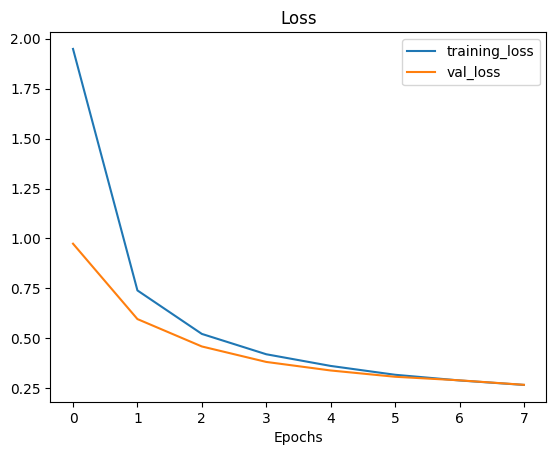

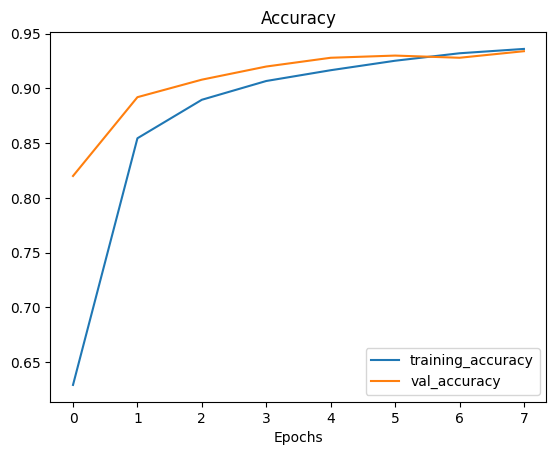

In [ ]:
plot_loss_curves(history)

## FINE-TUNING



In [ ]:
for layer in base_model.layers[-20:]:
  layer.trainable = True

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 50
history_fine_tune = model.fit(train_data,
          validation_data=val_data,
          epochs=fine_tune_epochs,
          initial_epoch=history.epoch[-1],
          callbacks=[checkpoint_callback,
                     early_stopping,
                     reduce_lr])


Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 51s 92ms/step - accuracy: 0.9257 - loss: 0.3090 - val_accuracy: 0.9480 - val_loss: 0.2174 - learning_rate: 1.0000e-04
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.9469 - loss: 0.2270 - val_accuracy: 0.9460 - val_loss: 0.1958 - learning_rate: 1.0000e-04
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.9507 - loss: 0.1955 - val_accuracy: 0.9520 - val_loss: 0.1863 - learning_rate: 1.0000e-04
Epoch 11/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.9554 - loss: 0.1795 - val_accuracy: 0.9520 - val_loss: 0.1766 - learning_rate: 1.0000e-04
Epoch 12/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9586 - loss: 0.1672 - val_accuracy: 0.9600 - val_loss: 0.1726 - learning_rate: 1.0000e-04
Epoch 13/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.9601 - loss: 0.1564 - val_accuracy: 0.9640 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 14/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 95

In [ ]:
test_loss_fine_tune, test_acc_fine_tune = model.evaluate(test_data)
print(f'Test loss after fine tuning: {test_loss_fine_tune}')
print(f'Tess accuracy after fine tuning: {test_acc_fine_tune}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.9670 - loss: 0.1260
Test loss after fine tuning: 0.11844713985919952
Tess accuracy after fine tuning: 0.972000002861023


In [ ]:
model.save('/gdrive/MyDrive/ButterflyandMoth100.keras' )

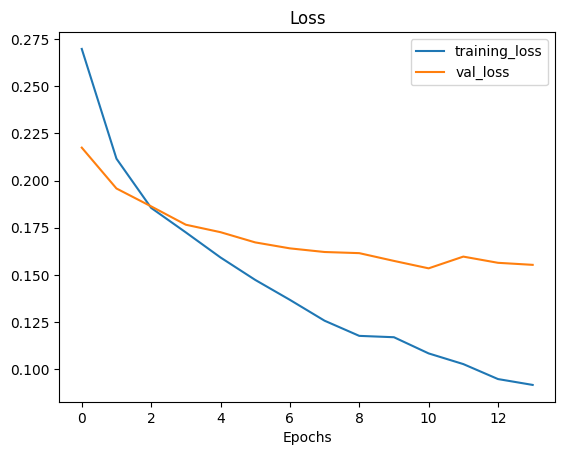

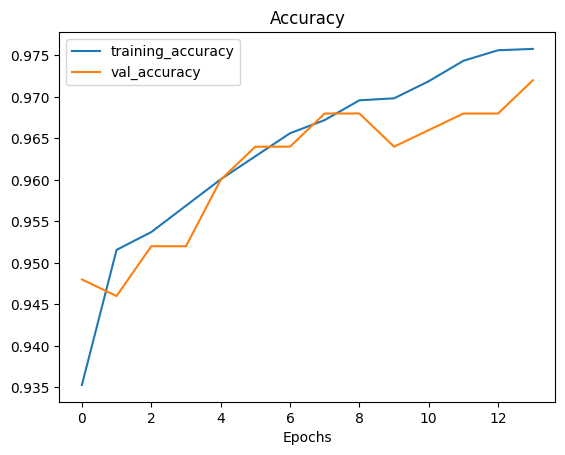

In [ ]:
plot_loss_curves(history_fine_tune)

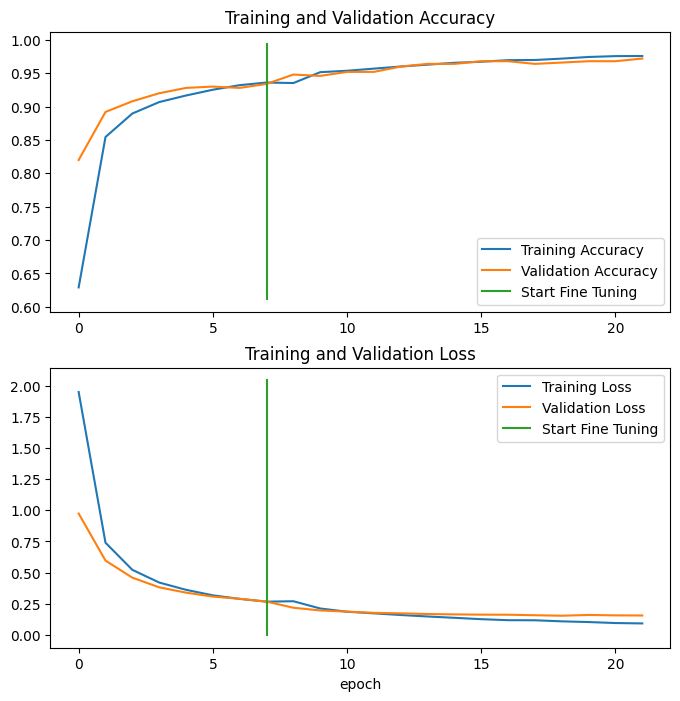

In [ ]:
compare_historys(original_history=history,
                 new_history=history_fine_tune, initial_epochs=8)

In [ ]:
pred_probs = model.predict(test_data, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

class_names = test_data.class_names

16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step


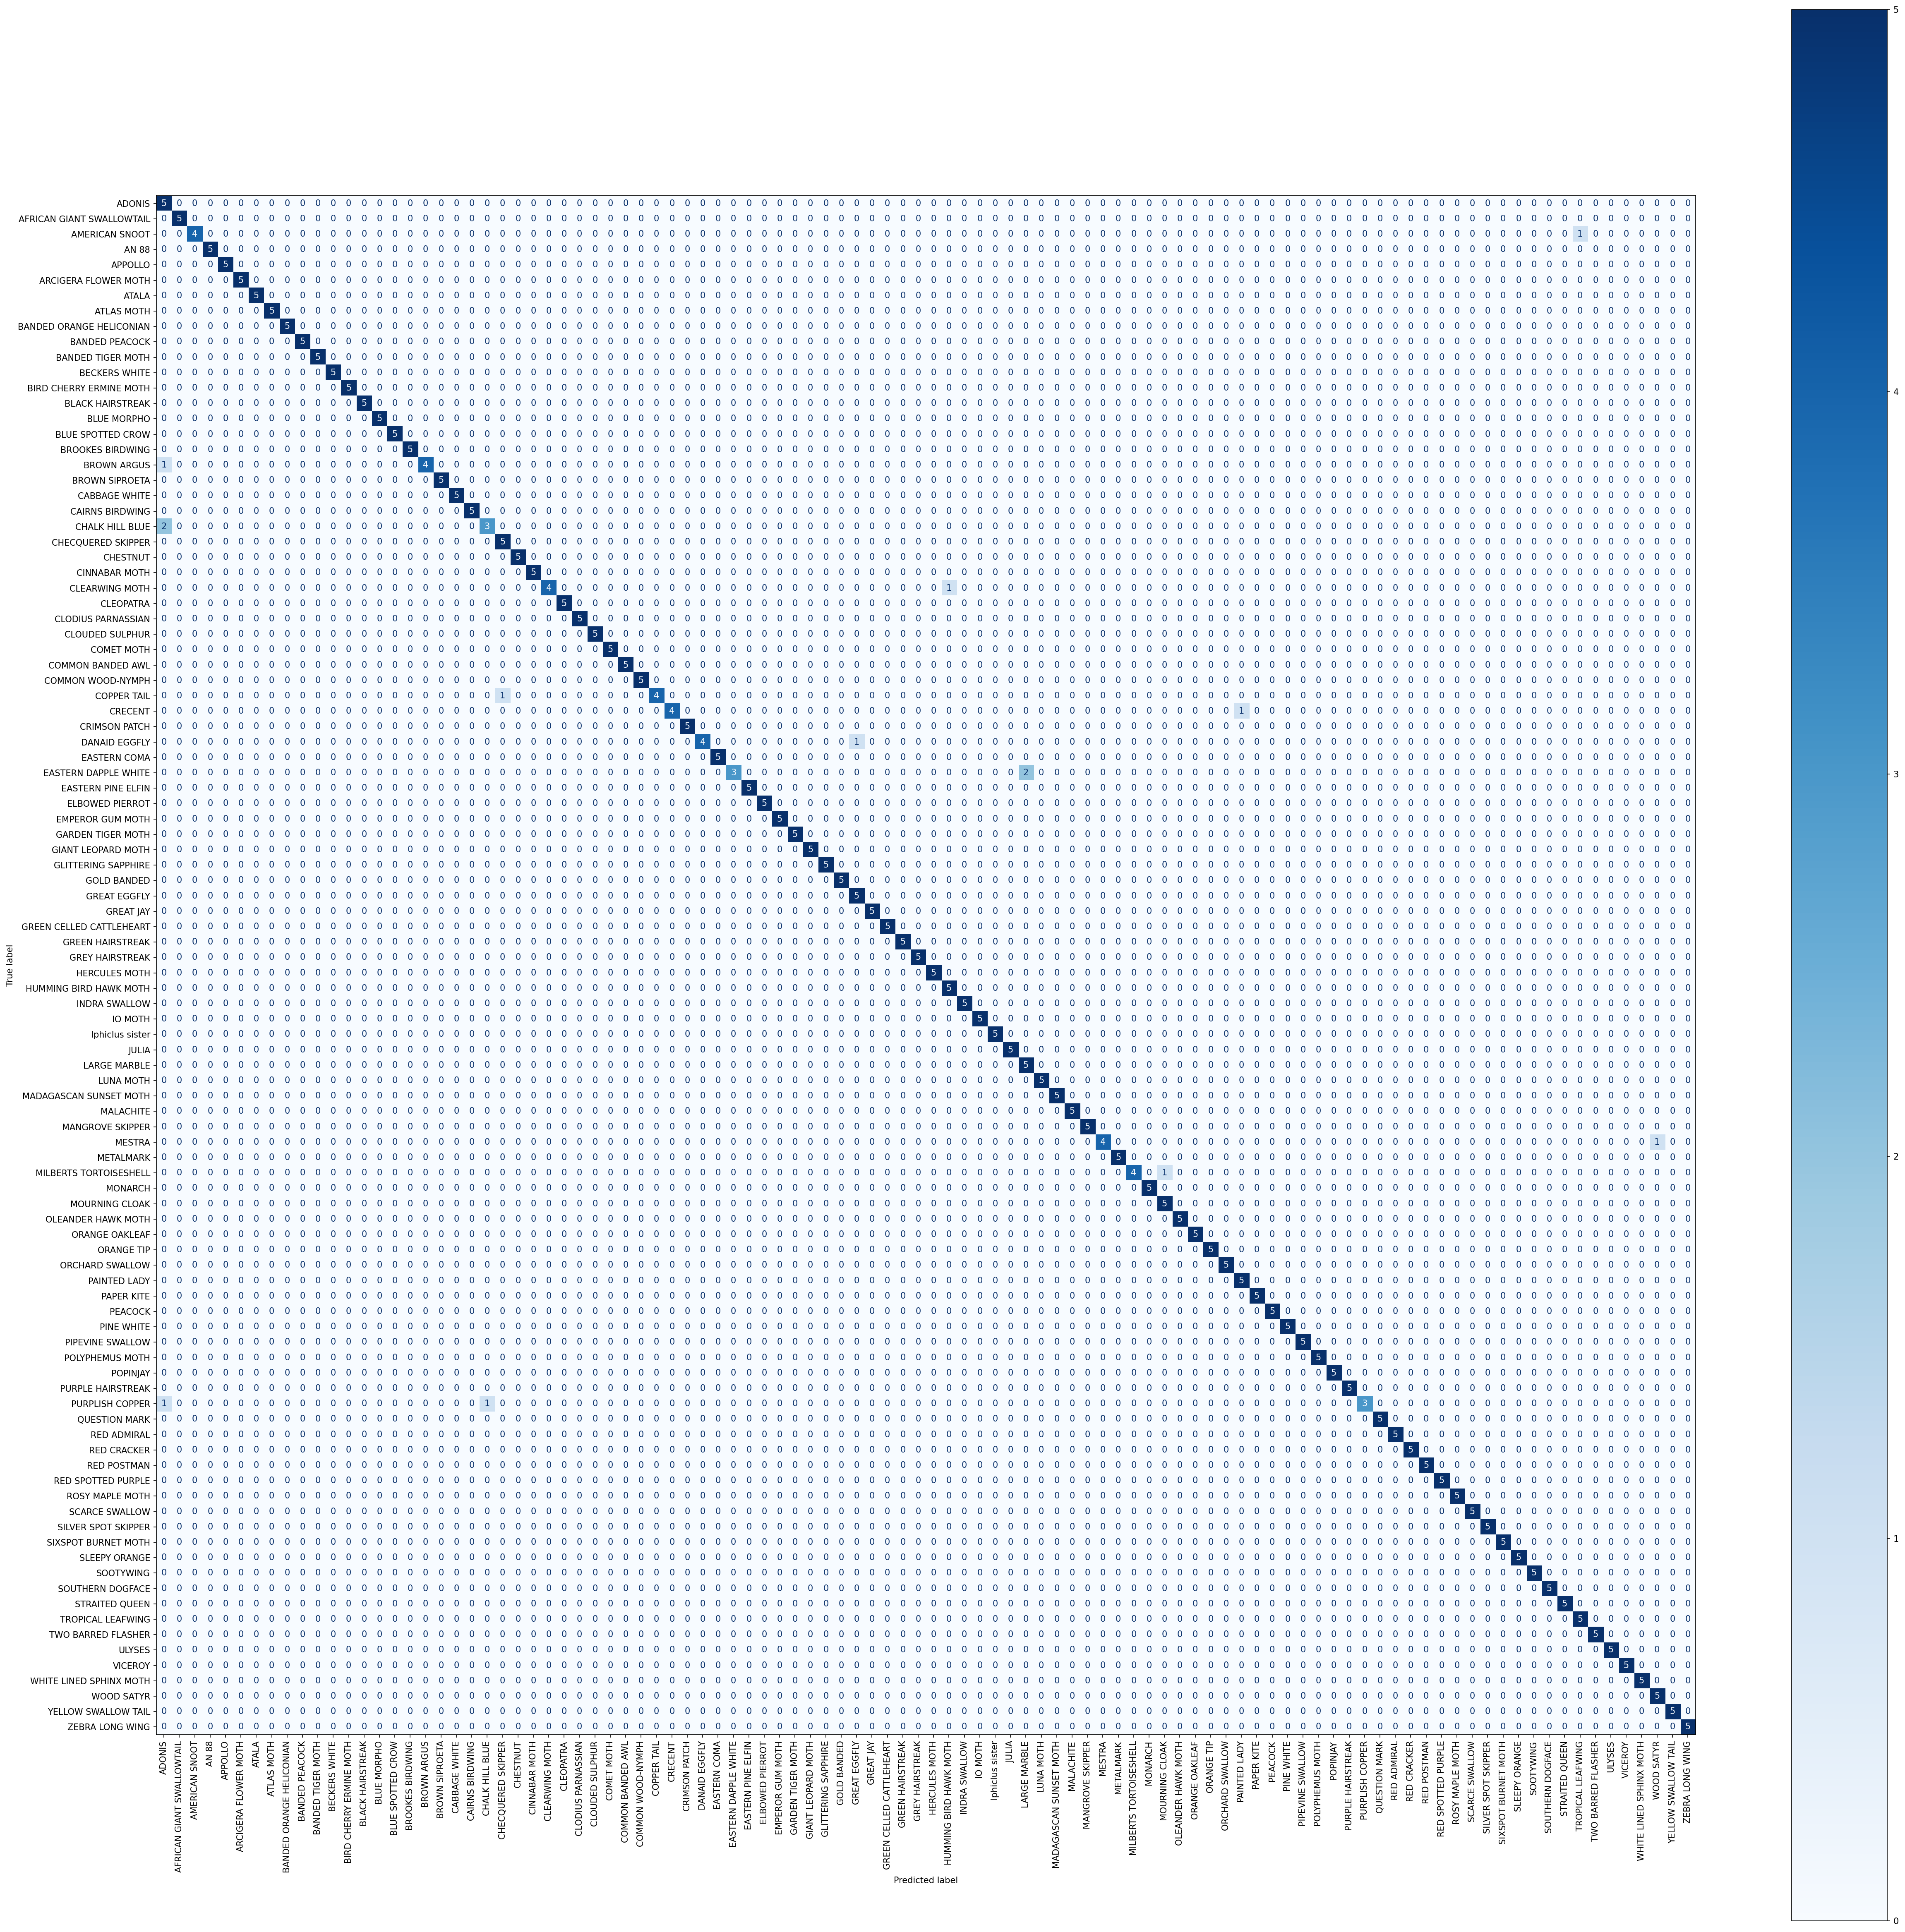

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40, 40), dpi=150)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=y_labels,
                                        y_pred=pred_classes,
                                        display_labels=class_names,
                                        cmap='Blues',
                                        xticks_rotation="vertical",
                                        ax = ax)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.56      1.00      0.71         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'ADONIS': 0.7142857142857143,
 'AFRICAN GIANT SWALLOWTAIL': 1.0,
 'AMERICAN SNOOT': 0.8888888888888888,
 'AN 88': 1.0,
 'APPOLLO': 1.0,
 'ARCIGERA FLOWER MOTH': 1.0,
 'ATALA': 1.0,
 'ATLAS MOTH': 1.0,
 'BANDED ORANGE HELICONIAN': 1.0,
 'BANDED PEACOCK': 1.0,
 'BANDED TIGER MOTH': 1.0,
 'BECKERS WHITE': 1.0,
 'BIRD CHERRY ERMINE MOTH': 1.0,
 'BLACK HAIRSTREAK': 1.0,
 'BLUE MORPHO': 1.0,
 'BLUE SPOTTED CROW': 1.0,
 'BROOKES BIRDWING': 1.0,
 'BROWN ARGUS': 0.8888888888888888,
 'BROWN SIPROETA': 1.0,
 'CABBAGE WHITE': 1.0,
 'CAIRNS BIRDWING': 1.0,
 'CHALK HILL BLUE': 0.6666666666666666,
 'CHECQUERED SKIPPER': 0.9090909090909091,
 'CHESTNUT': 1.0,
 'CINNABAR MOTH': 1.0,
 'CLEARWING MOTH': 0.8888888888888888,
 'CLEOPATRA': 1.0,
 'CLODIUS PARNASSIAN': 1.0,
 'CLOUDED SULPHUR': 1.0,
 'COMET MOTH': 1.0,
 'COMMON BANDED AWL': 1.0,
 'COMMON WOOD-NYMPH': 1.0,
 'COPPER TAIL': 0.8888888888888888,
 'CRECENT': 0.8888888888888888,
 'CRIMSON PATCH': 1.0,
 'DANAID EGGFLY': 0.8888888888888888,
 'EASTERN C

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()

class_name  f1-score
1   AFRICAN GIANT SWALLOWTAIL       1.0
3                       AN 88       1.0
5        ARCIGERA FLOWER MOTH       1.0
4                     APPOLLO       1.0
34              CRIMSON PATCH       1.0

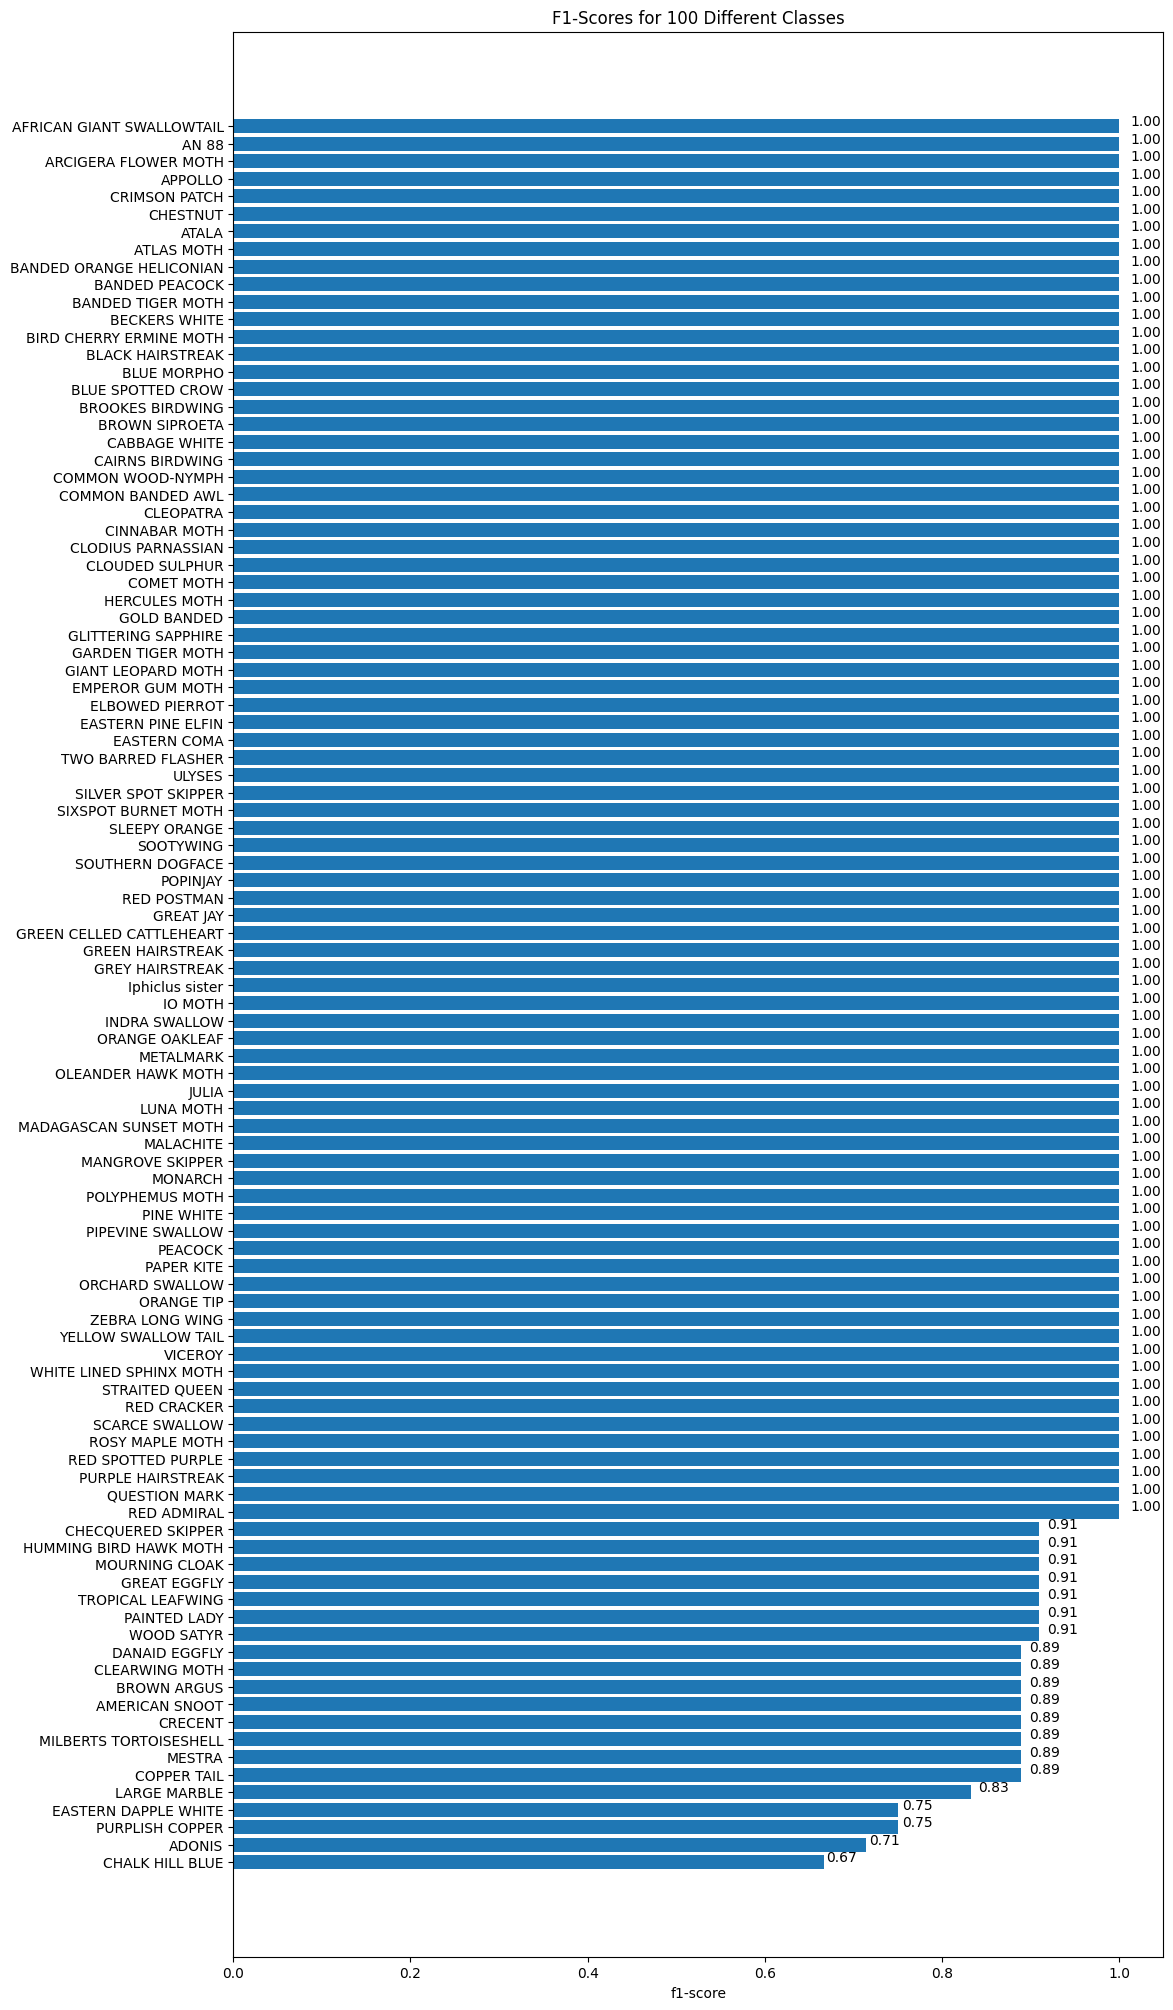

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 100 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('/gdrive/MyDrive/ButterflyandMoth100.keras')

In [ ]:
model.evaluate(test_data)

16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - accuracy: 0.9670 - loss: 0.1260


[0.11844713985919952, 0.972000002861023]

## EVALUATE MODEL ON CUSTOM DATASET

In [ ]:
import zipfile
zip_ref1 = zipfile.ZipFile('/gdrive/MyDrive/test2_data.zip','r')
zip_ref1.extractall('content/dataset')
zip_ref1.close()

In [ ]:
test2_data = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/content/dataset/test2_data',
                                                                 label_mode='int',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,
                                                                 shuffle=False
                                                                 )

Found 499 files belonging to 100 classes.


In [ ]:
test_loss, test_acc = model.evaluate(test2_data)
print(f'Test loss: {test_loss}')
print(f'Test accuracy dataset 2: {test_acc}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8934 - loss: 0.3348
Test loss: 0.334018737077713
Test accuracy dataset 2: 0.9078156352043152


In [ ]:
pred_probs2 = model.predict(test2_data, verbose=1)

# Get the class predictions of each label
pred_classes2 = pred_probs2.argmax(axis=1)

y_labels2 = []
for images, labels in test2_data.unbatch():
  y_labels2.append(labels.numpy())

class_names2 = test2_data.class_names

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step


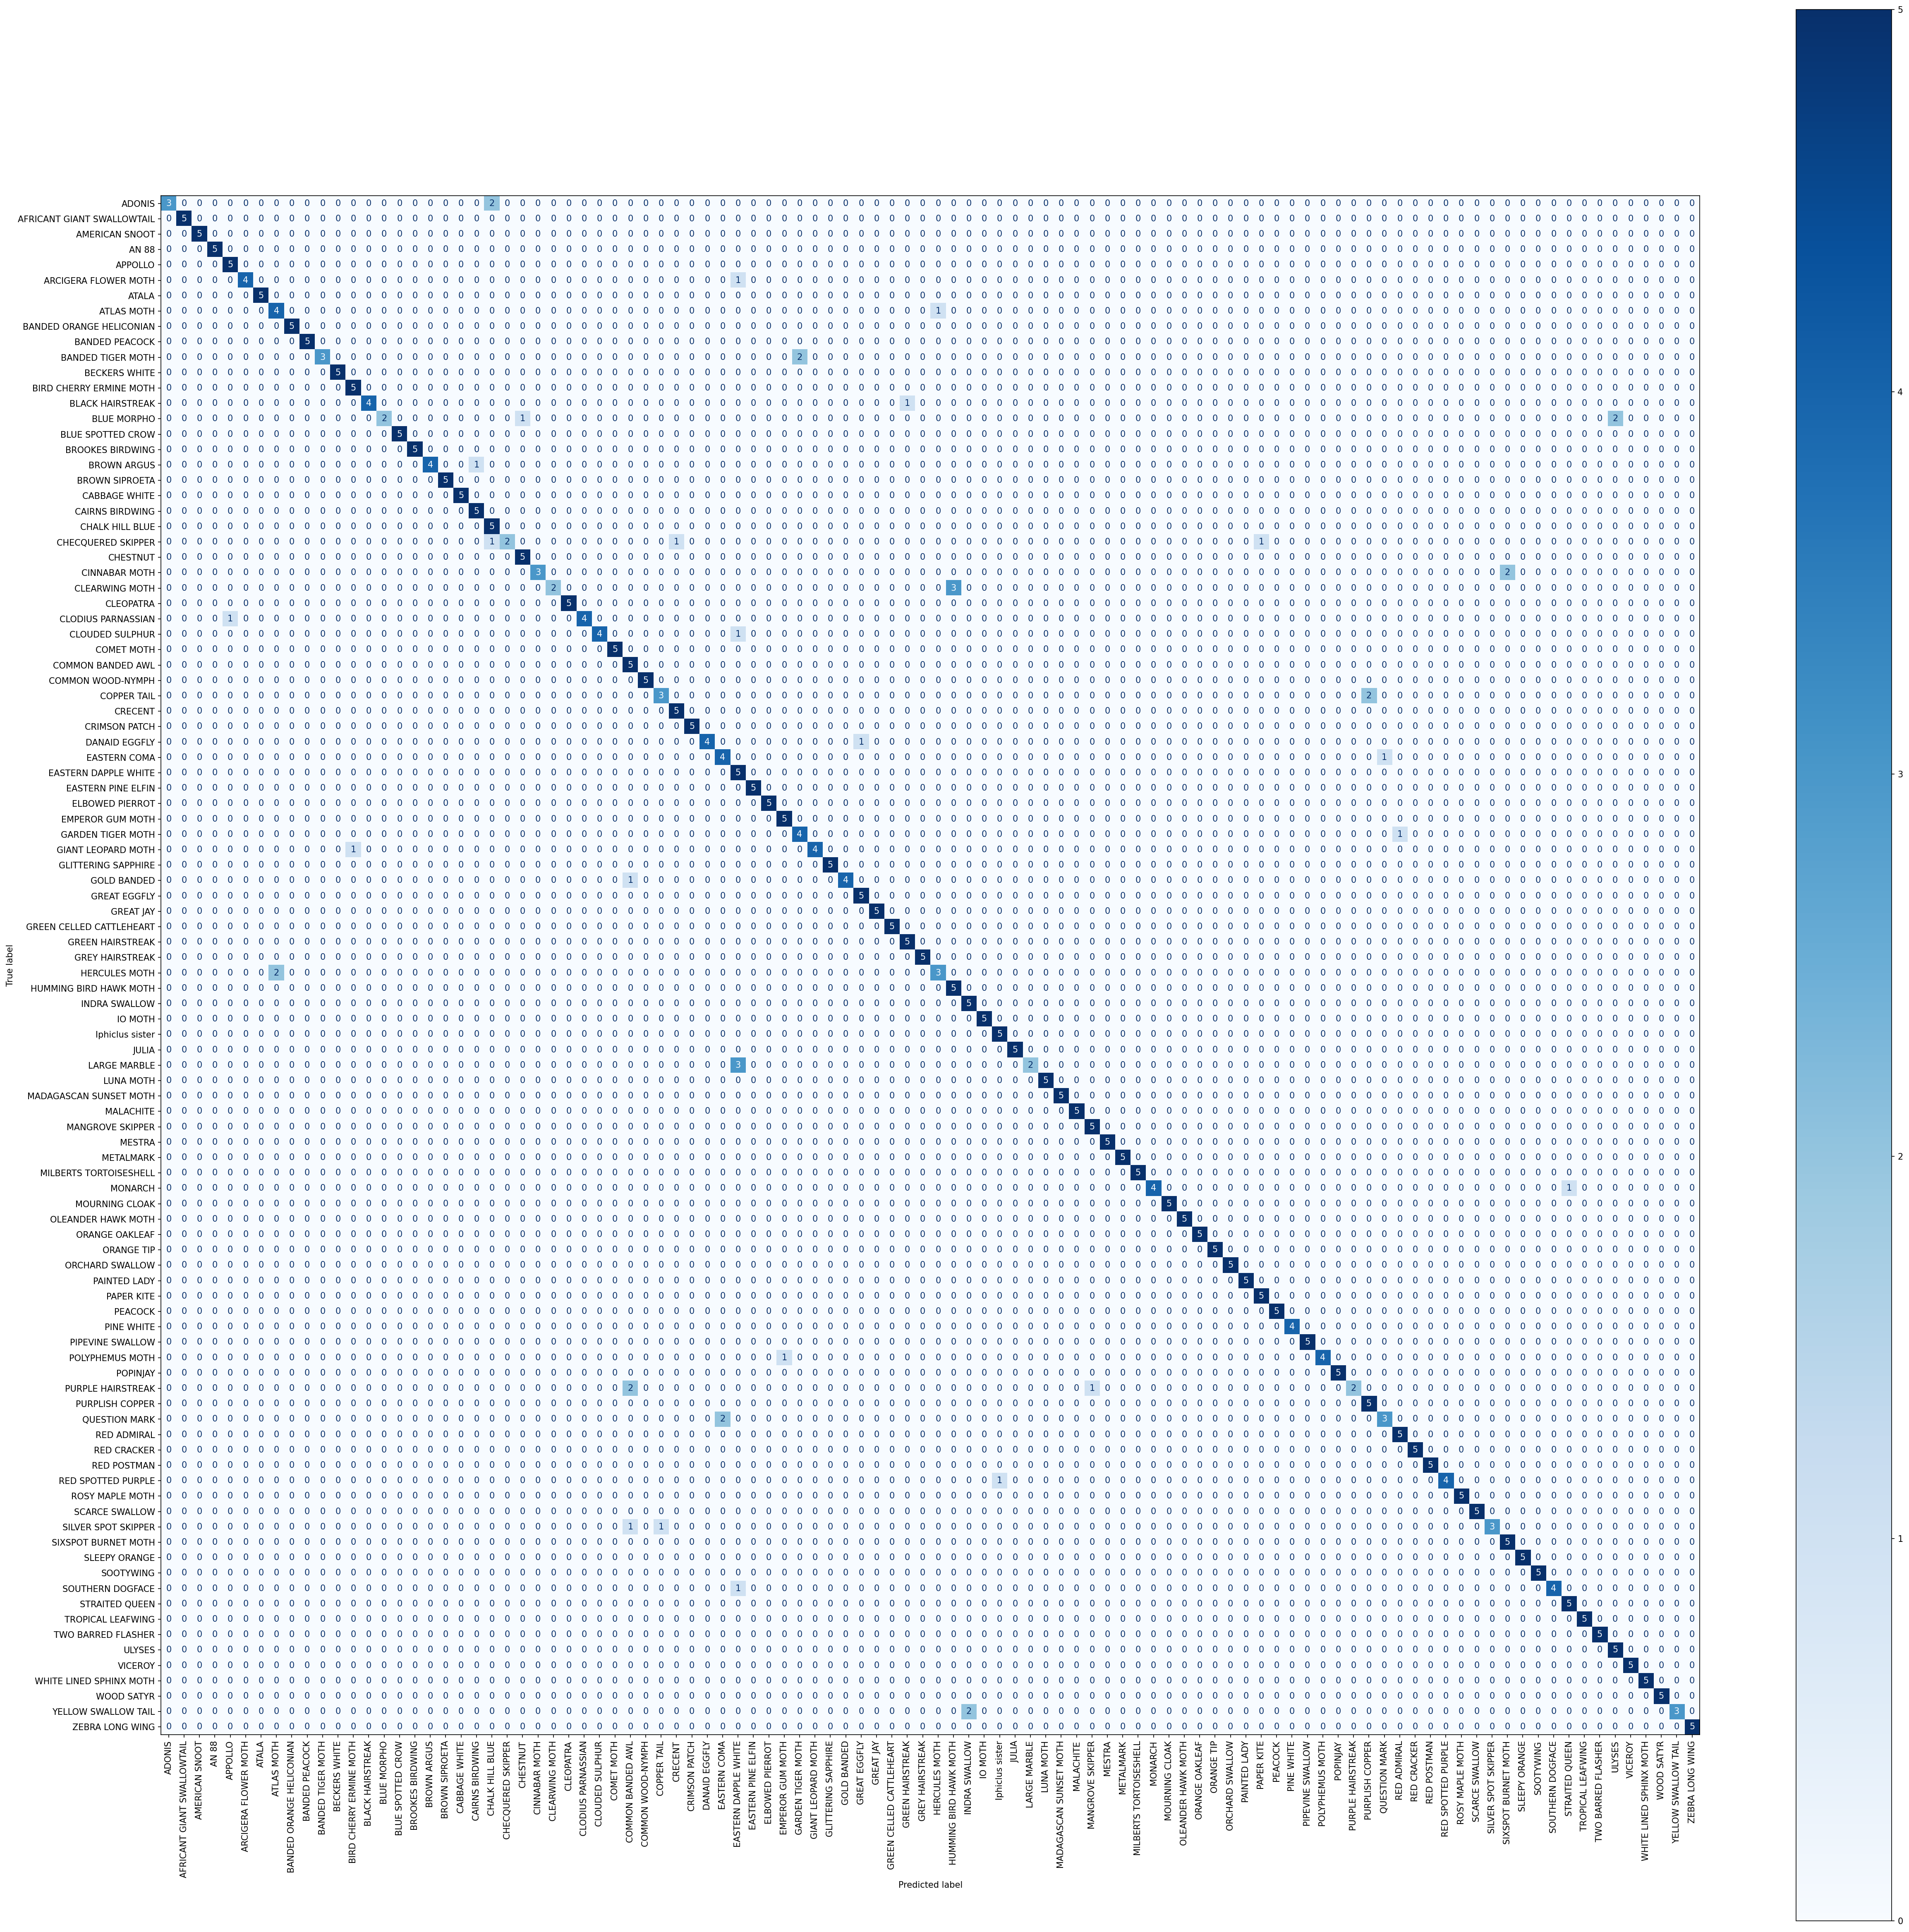

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40, 40), dpi=150)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=y_labels2,
                                        y_pred=pred_classes2,
                                        display_labels=class_names2,
                                        cmap='Blues',
                                        xticks_rotation="vertical",
                                        ax = ax)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels2, pred_classes2))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      0.60      0.75         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.00      0.80      0.89         5
          14       1.00      0.40      0.57         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict2 = classification_report(y_labels2, pred_classes2, output_dict=True)
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict2.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names2[int(k)]] = v["f1-score"]
class_f1_scores

{'ADONIS': 0.75,
 'AFRICANT GIANT SWALLOWTAIL': 1.0,
 'AMERICAN SNOOT': 1.0,
 'AN 88': 1.0,
 'APPOLLO': 0.9090909090909091,
 'ARCIGERA FLOWER MOTH': 0.8888888888888888,
 'ATALA': 1.0,
 'ATLAS MOTH': 0.7272727272727273,
 'BANDED ORANGE HELICONIAN': 1.0,
 'BANDED PEACOCK': 1.0,
 'BANDED TIGER MOTH': 0.75,
 'BECKERS WHITE': 1.0,
 'BIRD CHERRY ERMINE MOTH': 0.9090909090909091,
 'BLACK HAIRSTREAK': 0.8888888888888888,
 'BLUE MORPHO': 0.5714285714285714,
 'BLUE SPOTTED CROW': 1.0,
 'BROOKES BIRDWING': 1.0,
 'BROWN ARGUS': 0.8888888888888888,
 'BROWN SIPROETA': 1.0,
 'CABBAGE WHITE': 1.0,
 'CAIRNS BIRDWING': 0.9090909090909091,
 'CHALK HILL BLUE': 0.7692307692307693,
 'CHECQUERED SKIPPER': 0.5714285714285714,
 'CHESTNUT': 0.9090909090909091,
 'CINNABAR MOTH': 0.75,
 'CLEARWING MOTH': 0.5714285714285714,
 'CLEOPATRA': 1.0,
 'CLODIUS PARNASSIAN': 0.8888888888888888,
 'CLOUDED SULPHUR': 0.8888888888888888,
 'COMET MOTH': 1.0,
 'COMMON BANDED AWL': 0.7142857142857143,
 'COMMON WOOD-NYMPH': 1.0,
 

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


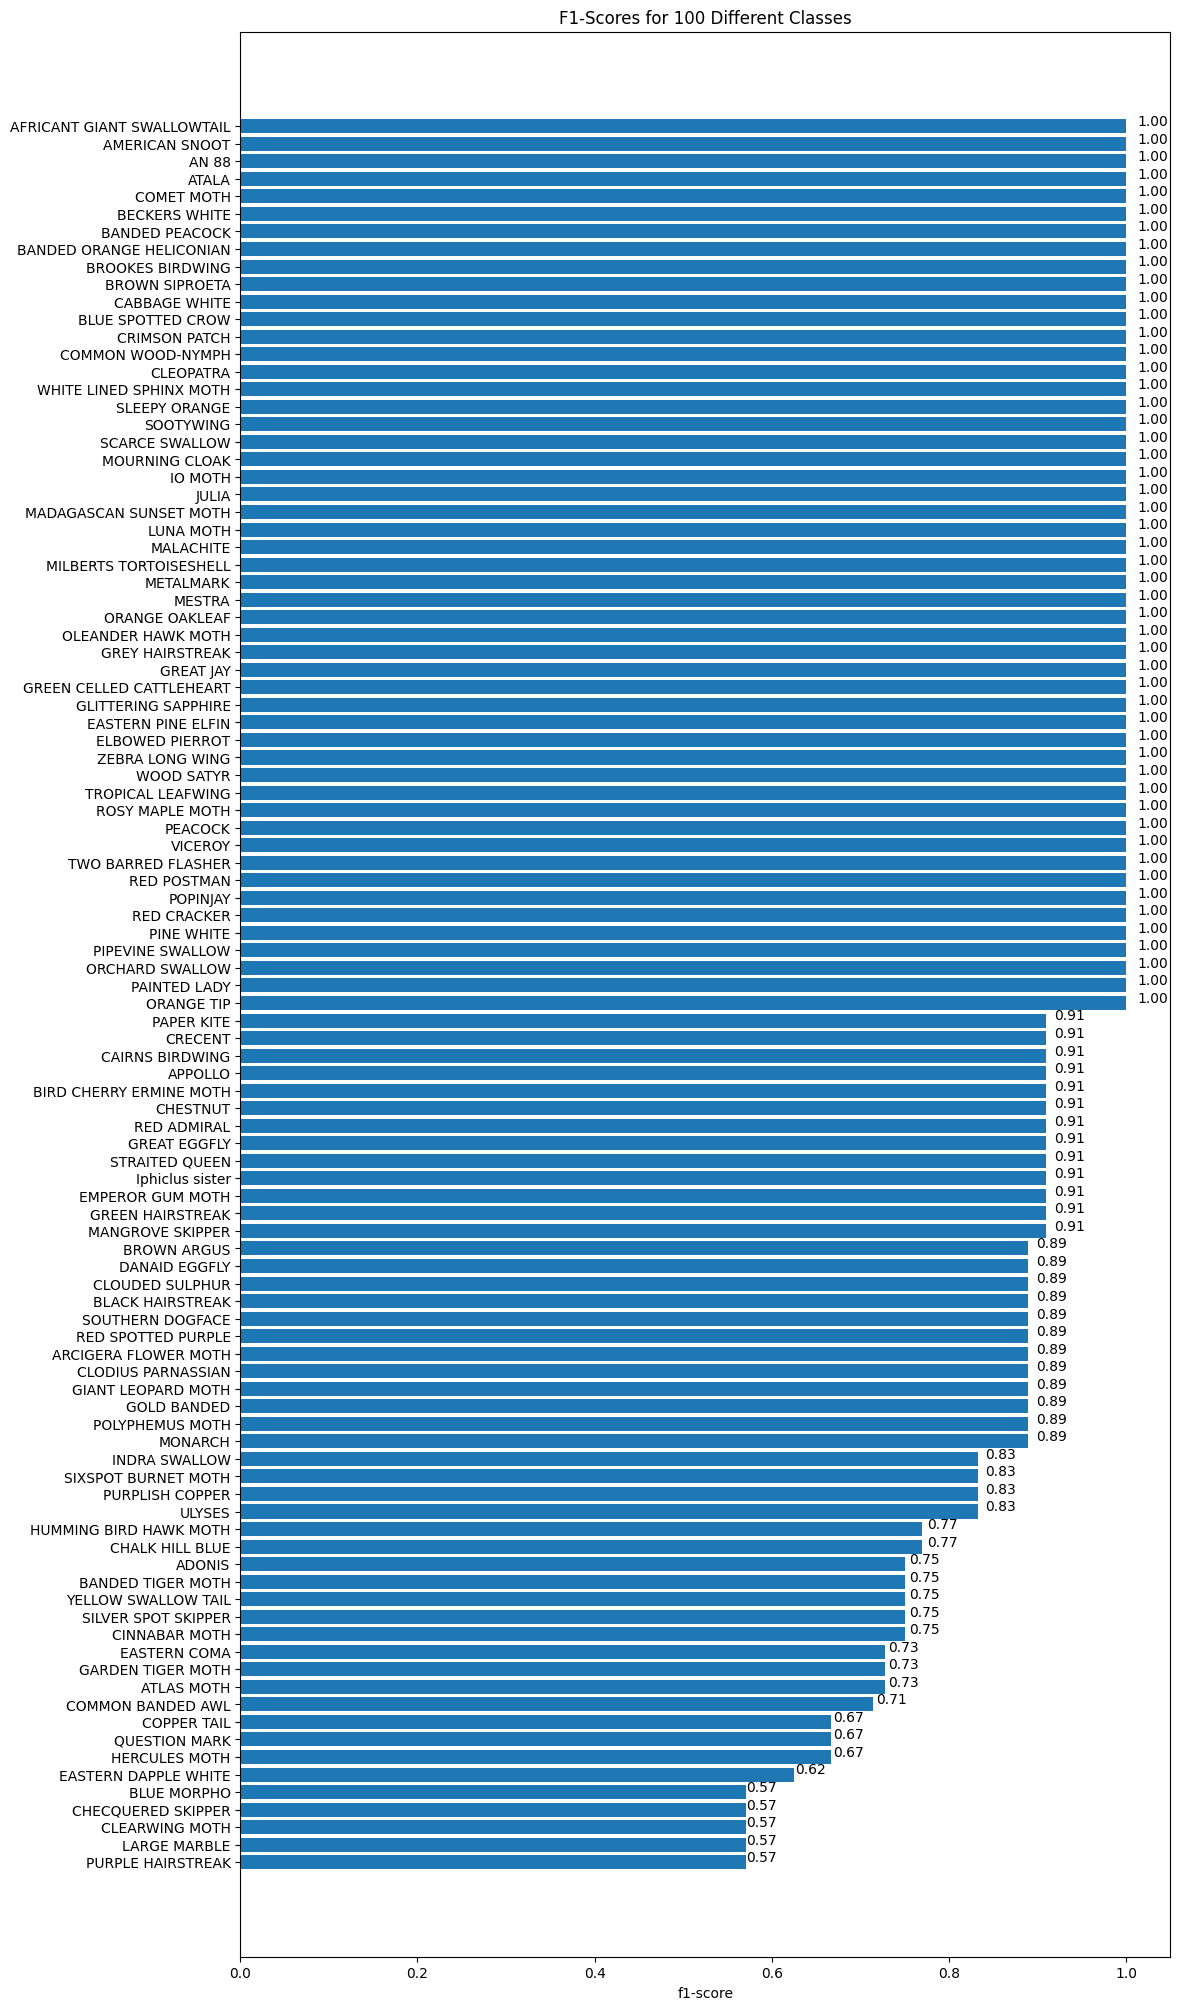

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 100 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


## CONTINUAL LEARNING

In [ ]:
zip_ref2 = zipfile.ZipFile('/gdrive/MyDrive/training2_data.zip','r')
zip_ref2.extractall('content/dataset')
zip_ref2.close()

In [ ]:
training2_data = tf.keras.preprocessing.image_dataset_from_directory(directory='/content/content/dataset/training2_data',
                                                                 label_mode='int',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMAGE_SIZE,

                                                                 )

Found 537 files belonging to 100 classes.


In [ ]:
import tensorflow as tf
import keras

linear_activation = keras.activations.get("linear")

student = tf.keras.models.load_model(
    "/gdrive/MyDrive/ButterflyandMoth100.keras",
    compile=False
)
student.get_layer("output_layer").activation = linear_activation


teacher = tf.keras.models.load_model(
    "/gdrive/MyDrive/ButterflyandMoth100.keras",
    compile=False
)
teacher.get_layer("output_layer").activation = linear_activation

teacher.trainable = False




In [ ]:
def replay_per_class(dataset, n_per_class, num_classes=100):
    xs, ys = [], []
    counter = {i: 0 for i in range(num_classes)}

    for x, y in dataset.unbatch():
        label = int(y.numpy())
        if counter[label] < n_per_class:
            xs.append(x)
            ys.append(y)
            counter[label] += 1
        if all(v == n_per_class for v in counter.values()):
            break

    xs = tf.stack(xs)
    ys = tf.stack(ys)

    return tf.data.Dataset.from_tensor_slices((xs, ys))


In [ ]:
def fix_shape(x, y):
    x = tf.image.resize(x, [224, 224])
    x = tf.cast(x, tf.float32)
    x = tf.ensure_shape(x, [224, 224, 3])
    y = tf.cast(y, tf.int32)
    return x, y

train_new = (
    training2_data
    .unbatch()
    .map(fix_shape, num_parallel_calls=tf.data.AUTOTUNE)
)

replay_A = replay_per_class(train_data, n_per_class=24)

replay_A = replay_A.map(
    fix_shape,
    num_parallel_calls=tf.data.AUTOTUNE
)
train_CL = tf.data.Dataset.sample_from_datasets(
    [train_new.repeat(), replay_A.repeat()],
    weights=[0.25, 0.75],
    seed=42
)

train_CL = train_CL.batch(32, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

print(train_CL.element_spec)

(TensorSpec(shape=(32, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(32,), dtype=tf.int32, name=None))


In [ ]:
import tensorflow as tf
import keras

class LogitsDistillation(keras.losses.Loss):
    def __init__(self, temperature=3.0, **kwargs):
        super().__init__(**kwargs)
        self.temperature = temperature

    def call(self, teacher_logits, student_logits):
        t = self.temperature
        teacher_probs = tf.nn.softmax(teacher_logits / t)
        student_log_probs = tf.nn.log_softmax(student_logits / t)

        # Cross-entropy phần KD * T^2
        kd_loss = -tf.reduce_sum(teacher_probs * student_log_probs, axis=1)
        return tf.reduce_mean(kd_loss) * (t ** 2)




In [ ]:

class FeatureDistillation(keras.losses.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.mse = keras.losses.MeanSquaredError()

    def call(self, teacher_feat, student_feat):
        # 1. Global Average Pooling nếu là 4D tensor
        if len(teacher_feat.shape) == 4:
            teacher_feat = tf.reduce_mean(teacher_feat, axis=[1, 2])
        if len(student_feat.shape) == 4:
            student_feat = tf.reduce_mean(student_feat, axis=[1, 2])

        # 2. L2 Normalize (Rất quan trọng để so sánh hướng vector)
        t_feat_norm = tf.nn.l2_normalize(teacher_feat, axis=-1)
        s_feat_norm = tf.nn.l2_normalize(student_feat, axis=-1)

        return self.mse(t_feat_norm, s_feat_norm)


In [ ]:
class Distiller(keras.Model):
    def __init__(
        self,
        teacher,
        student,
        layer_name_teacher, # Tên layer muốn lấy feature của Teacher
        layer_name_student, # Tên layer muốn lấy feature của Student
        lambda_kd=2.0,     # Hệ số tổng cho KD
        distill_weights=[0.6, 0.4], # [Weight Logits, Weight Feature]
        temperature=5.0,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.teacher = teacher
        self.student = student
        self.lambda_kd = lambda_kd
        self.distill_weights = distill_weights
        self.temperature = temperature

        # Tạo extractor trả về [Logits, Features]
        self.teacher_extractor = self._make_extractor(teacher, layer_name_teacher)
        self.student_extractor = self._make_extractor(student, layer_name_student)

        # Loss functions
        self.student_loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        self.logits_loss_fn = LogitsDistillation(temperature=temperature)
        self.feat_loss_fn = FeatureDistillation()

    def _make_extractor(self, model, layer_name):
        # Hàm này tạo một model giả, output ra 2 thứ: Logits và Feature layer
        try:
            output_layer = model.get_layer(layer_name).output
        except ValueError:
            print(f"⚠️ Cảnh báo: Không tìm thấy layer tên '{layer_name}'.")
            print("Các layer khả dụng cuối cùng:", [l.name for l in model.layers[-10:]])
            raise

        return keras.Model(
            inputs=model.input,
            outputs=[model.output, output_layer] # [Logits, Feature]
        )

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer, metrics=metrics)

    def train_step(self, data):
        x, y = data

        # 1. Forward Teacher (1 lần duy nhất)
        # Trả về tuple: (logits, features)
        t_logits, t_feat = self.teacher_extractor(x, training=False)

        with tf.GradientTape() as tape:
            # 2. Forward Student (1 lần duy nhất)
            s_logits, s_feat = self.student_extractor(x, training=True)

            # 3. Hard Loss (Ground Truth)
            loss_student = self.student_loss_fn(y, s_logits)

            # 4. Distillation Losses
            # a. Logits KD
            loss_logits = self.logits_loss_fn(t_logits, s_logits)

            # b. Feature KD
            loss_feat = self.feat_loss_fn(t_feat, s_feat)

            # 5. Tổng hợp Loss
            # Total = Hard + lambda * (w1*Logits + w2*Feature)
            w_logits, w_feat = self.distill_weights
            distill_total = (w_logits * loss_logits) + (w_feat * loss_feat)

            total_loss = loss_student + (self.lambda_kd * distill_total)

        # 6. Backprop
        grads = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.student.trainable_variables))

        # Update metrics
        self.compiled_metrics.update_state(y, s_logits)

        return {
            "loss": total_loss,
            "s_loss": loss_student,
            "kd_logits": loss_logits,
            "kd_feat": loss_feat
        }

    def test_step(self, data):
        x, y = data
        y_pred, _ = self.student_extractor(x, training=False)
        loss = self.student_loss_fn(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        results = {m.name: m.result() for m in self.metrics}
        results["loss"] = loss

        return results

In [ ]:
distiller = Distiller(
    teacher=teacher,
    student=student,
    layer_name_teacher="global_average_pooling",
    layer_name_student="global_average_pooling",
    lambda_kd=1.0,
    distill_weights=[0.4, 0.6],
    temperature=5.0
)

distiller.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)


In [ ]:
distiller.fit(
    train_CL,
    epochs=10,
    steps_per_epoch = 52,
    validation_data=test2_data,
    )

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:646: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 217ms/step - kd_feat: 4.0865e-04 - kd_logits: 104.1496 - loss: 41.8429 - s_loss: 0.1828 - accuracy: 0.9158 - val_loss: 0.2379
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - kd_feat: 4.0637e-04 - kd_logits: 104.1928 - loss: 41.8298 - s_loss: 0.1525 - accuracy: 0.9178 - val_loss: 0.1903
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - kd_feat: 3.9431e-04 - kd_logits: 103.9262 - loss: 41.7018 - s_loss: 0.1311 - accuracy: 0.9238 - val_loss: 0.1670
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - kd_feat: 3.9707e-04 - kd_logits: 104.0455 - loss: 41.7580 - s_loss: 0.1396 - accuracy: 0.9299 - val_loss: 0.1529
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - kd_feat: 3.9641e-04 - kd_logits: 104.0663 - loss: 41.7686 - s_loss: 0.1418 - accuracy: 0.9299 - val_loss: 0.1422
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - kd_feat: 3.9367e-04 - kd_logits: 104.0085 - loss: 41.7446 - s_loss: 0.1409 - accuracy: 0.9319 - val_loss: 0.1251
Epoch 7/

In [ ]:
student.save("/gdrive/MyDrive/butterfly_continual_model.keras")


In [ ]:
student_loaded = tf.keras.models.load_model("/gdrive/MyDrive/butterfly_continual_model.keras")

In [ ]:

student_loaded.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
loss, acc = student_loaded.evaluate(test2_data)
print(f"Test loss: {loss:.4f}, Test 2 accuracy on model 2: {acc:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.9183 - loss: 0.2595
Test loss: 0.2502, Test 2 accuracy on model 2: 0.9339


In [ ]:
loss, acc = student_loaded.evaluate(test_data)
print(f"Test loss: {loss:.4f}, Test 1 accuracy on model 2: {acc:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9651 - loss: 0.1289
Test loss: 0.1223, Test 1 accuracy on model 2: 0.9680


In [ ]:
pred_probs = student_loaded.predict(test_data, verbose=1)

# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy())

class_names = test_data.class_names

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.71      1.00      0.83         5
           1       1.00      1.00      1.00         5
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       0.83      1.00      0.91         5
          12       1.00      0.80      0.89         5
          13       1.00      1.00      1.00         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

In [ ]:
pred_probs2 = student_loaded.predict(test2_data, verbose=1)

# Get the class predictions of each label
pred_classes2 = pred_probs2.argmax(axis=1)

y_labels2 = []
for images, labels in test2_data.unbatch():
  y_labels2.append(labels.numpy())

class_names2 = test2_data.class_names

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_labels2, pred_classes2))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       0.83      1.00      0.91         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       0.83      1.00      0.91         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      0.60      0.75         5
          11       1.00      0.80      0.89         5
          12       1.00      1.00      1.00         5
          13       1.00      1.00      1.00         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

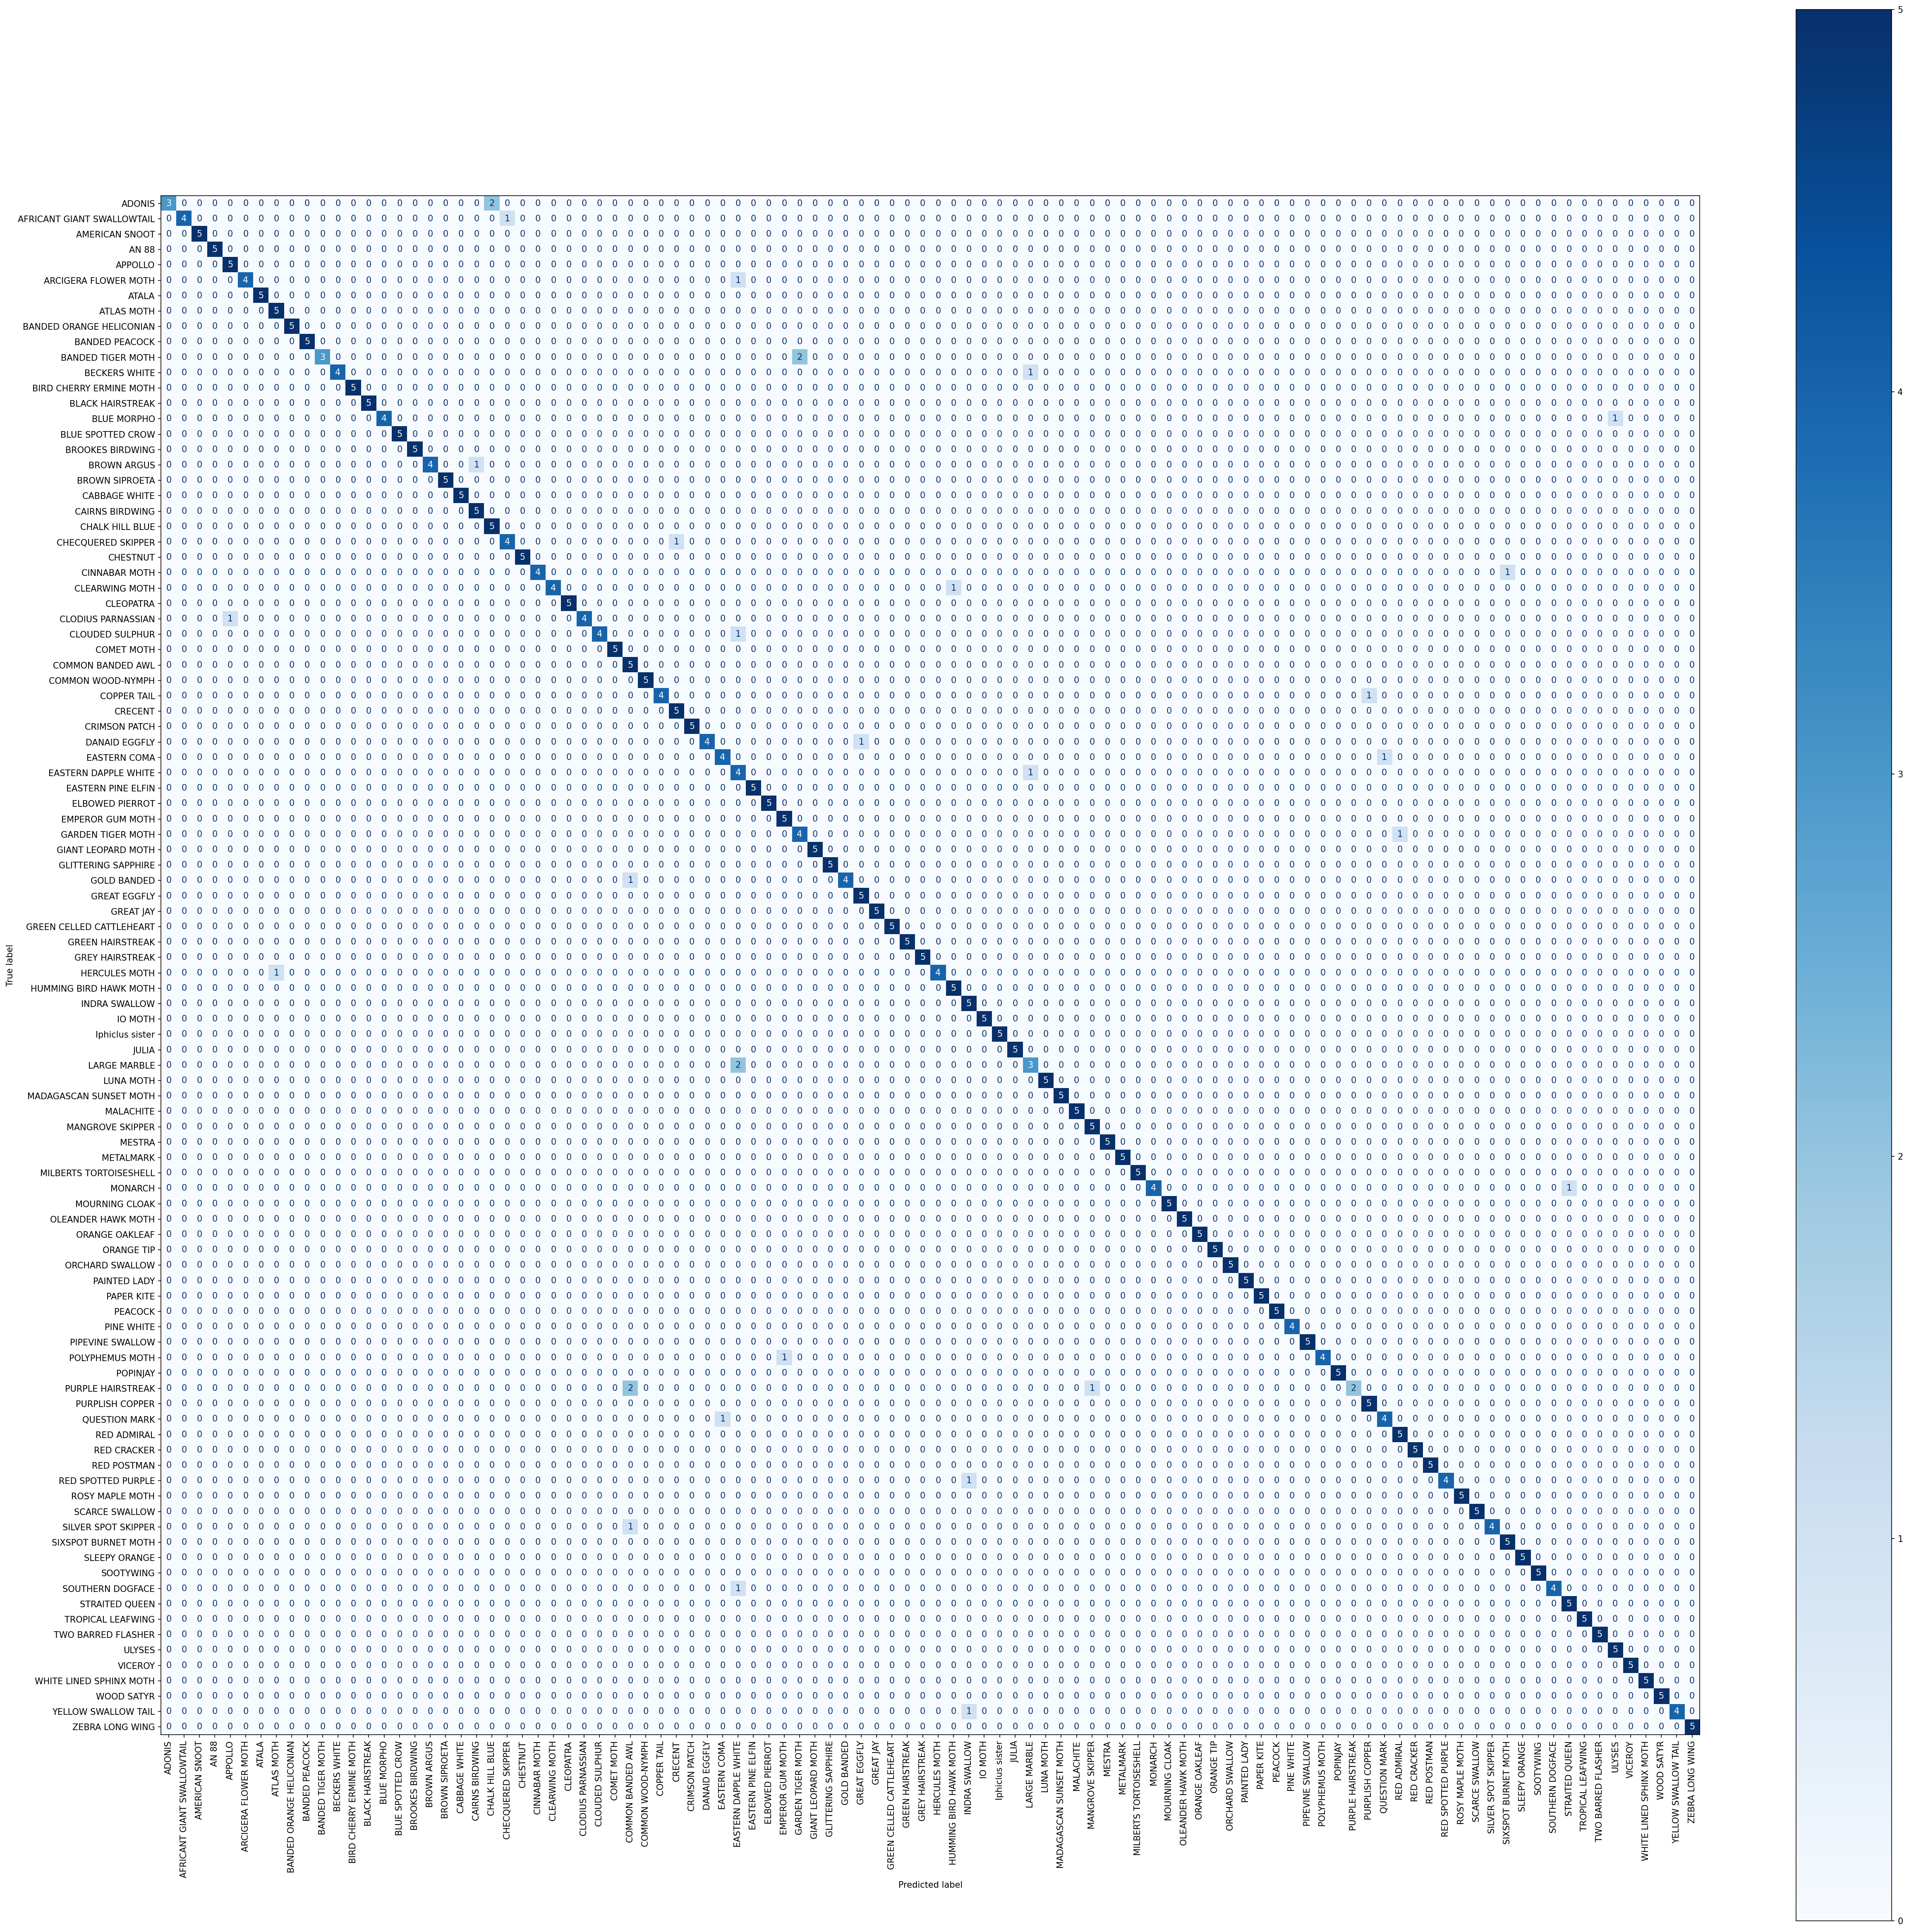

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(40, 40), dpi=150)

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=y_labels2,
                                        y_pred=pred_classes2,
                                        display_labels=class_names2,
                                        cmap='Blues',
                                        xticks_rotation="vertical",
                                        ax = ax)

In [ ]:
from sklearn.metrics import classification_report
# Get a dictionary of the classification report
classification_report_dict2 = classification_report(y_labels2, pred_classes2, output_dict=True)
# Create empty dictionary
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict2.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[class_names2[int(k)]] = v["f1-score"]
class_f1_scores

{'ADONIS': 0.75,
 'AFRICANT GIANT SWALLOWTAIL': 0.8888888888888888,
 'AMERICAN SNOOT': 1.0,
 'AN 88': 1.0,
 'APPOLLO': 0.9090909090909091,
 'ARCIGERA FLOWER MOTH': 0.8888888888888888,
 'ATALA': 1.0,
 'ATLAS MOTH': 0.9090909090909091,
 'BANDED ORANGE HELICONIAN': 1.0,
 'BANDED PEACOCK': 1.0,
 'BANDED TIGER MOTH': 0.75,
 'BECKERS WHITE': 0.8888888888888888,
 'BIRD CHERRY ERMINE MOTH': 1.0,
 'BLACK HAIRSTREAK': 1.0,
 'BLUE MORPHO': 0.8888888888888888,
 'BLUE SPOTTED CROW': 1.0,
 'BROOKES BIRDWING': 1.0,
 'BROWN ARGUS': 0.8888888888888888,
 'BROWN SIPROETA': 1.0,
 'CABBAGE WHITE': 1.0,
 'CAIRNS BIRDWING': 0.9090909090909091,
 'CHALK HILL BLUE': 0.8333333333333334,
 'CHECQUERED SKIPPER': 0.8,
 'CHESTNUT': 1.0,
 'CINNABAR MOTH': 0.8888888888888888,
 'CLEARWING MOTH': 0.8888888888888888,
 'CLEOPATRA': 1.0,
 'CLODIUS PARNASSIAN': 0.8888888888888888,
 'CLOUDED SULPHUR': 0.8888888888888888,
 'COMET MOTH': 1.0,
 'COMMON BANDED AWL': 0.7142857142857143,
 'COMMON WOOD-NYMPH': 1.0,
 'COPPER TAIL': 0

In [ ]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


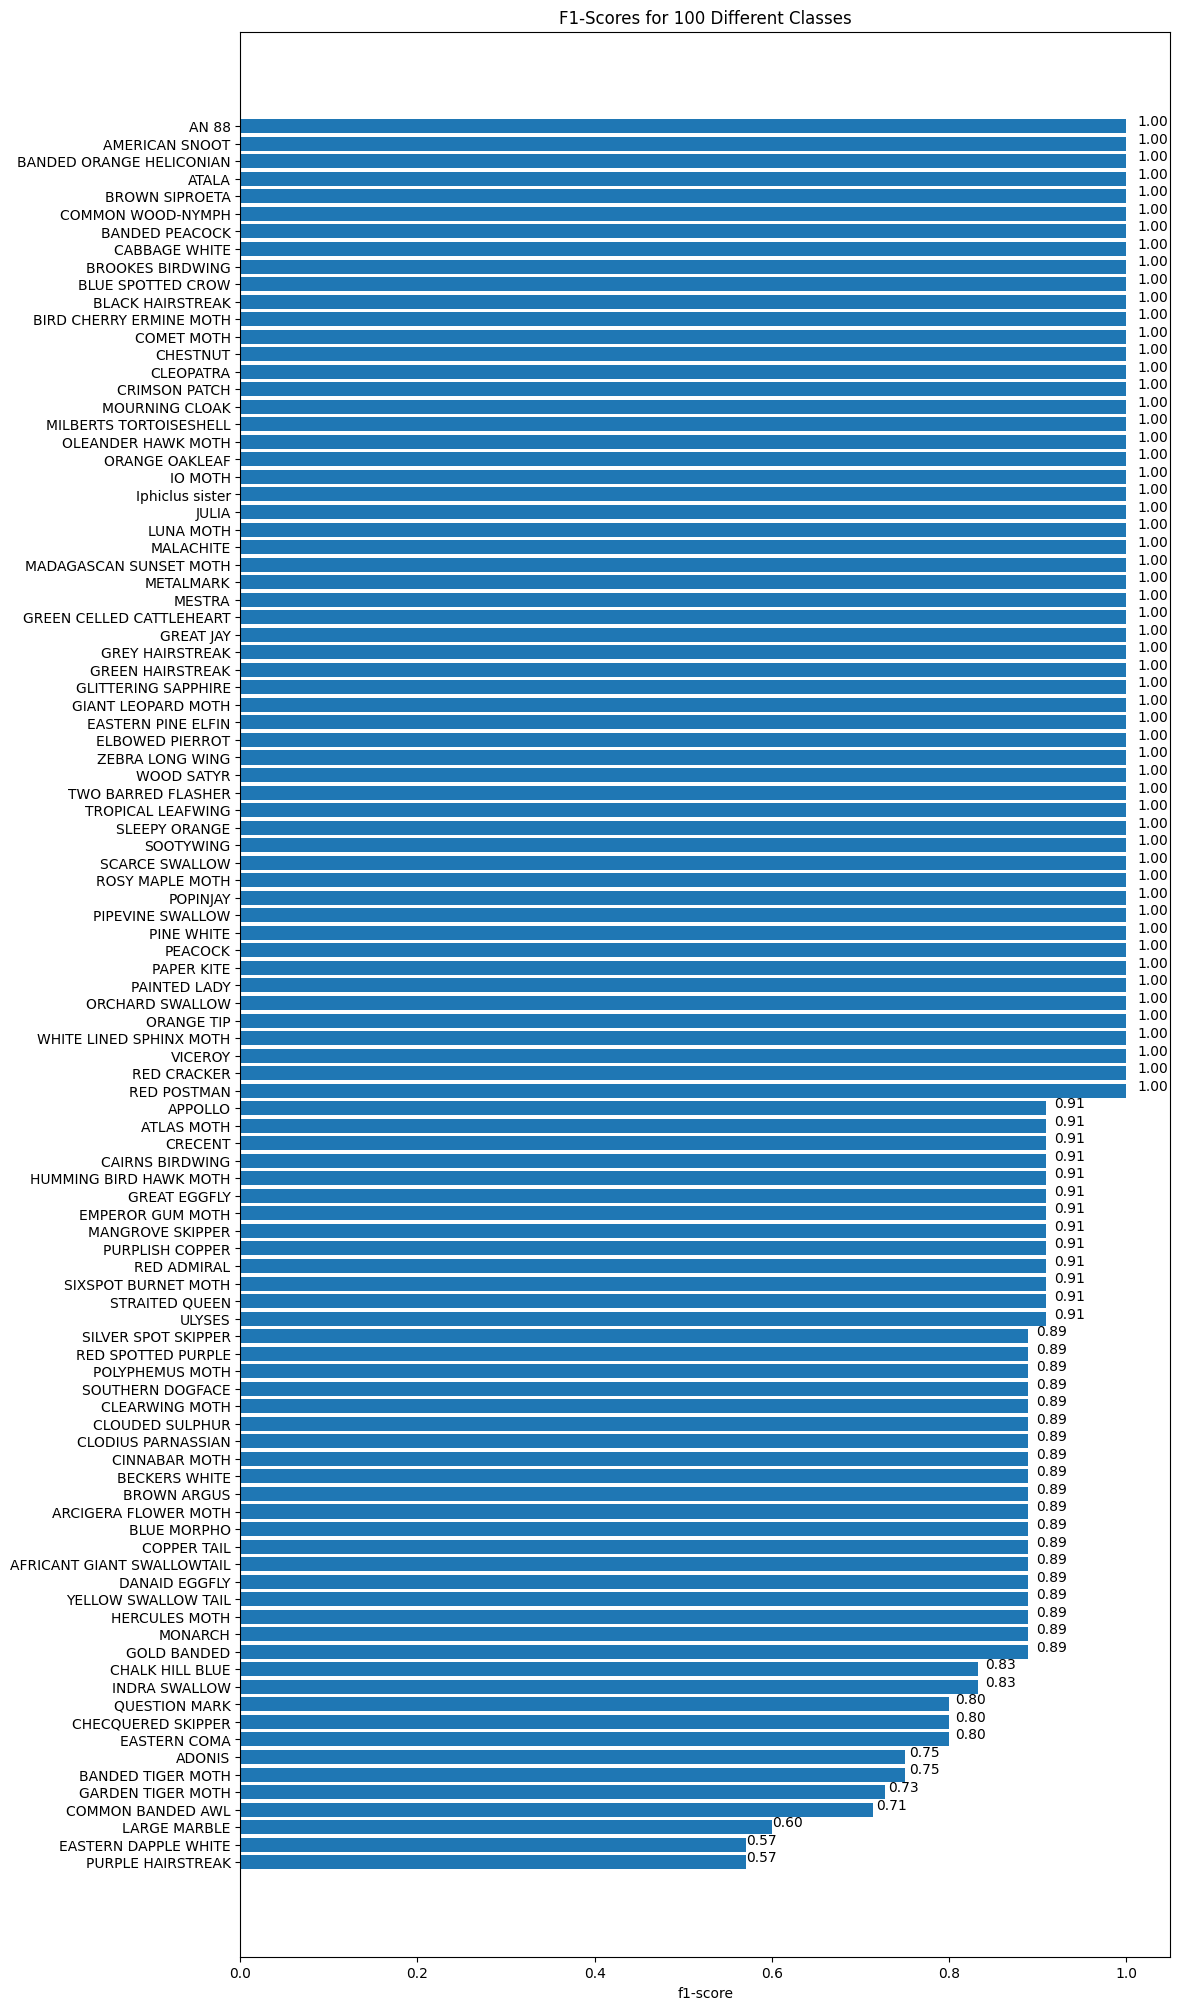

In [ ]:

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 100 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


##DEPLOYMENT

In [ ]:
!pip install streamlit pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 94.2 MB/s eta 0:00:00


In [ ]:
import os

# ⚠️ QUAN TRỌNG: Thay đường dẫn bên dưới bằng đường dẫn tới thư mục chứa ảnh train
# Ví dụ: '/gdrive/MyDrive/ButterflyDataset/train'
dataset_path = '/content/content/dataset/train'

try:
    # Lấy tên các thư mục con và sắp xếp theo thứ tự alpha (mặc định của Keras)
    class_names = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    # Lưu vào file labels.txt
    with open('labels.txt', 'w') as f:
        for name in class_names:
            f.write(name + '\n')

    print(f"✅ Đã tìm thấy {len(class_names)} loài.")
    print("✅ Đã tạo thành công file 'labels.txt'.")
    print("👉 5 tên đầu tiên:", class_names[:5])

except Exception as e:
    print("❌ Lỗi: Không tìm thấy thư mục. Hãy kiểm tra lại đường dẫn dataset_path!")
    print(e)

✅ Đã tìm thấy 100 loài.
✅ Đã tạo thành công file 'labels.txt'.
👉 5 tên đầu tiên: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO']


In [ ]:
%%writefile app.py
import streamlit as st
import tensorflow as tf
from PIL import Image
import numpy as np

# --- 1. LOAD LABELS ---
def load_labels():
    try:
        with open("labels.txt", "r") as f:
            return [line.strip() for line in f.readlines()]
    except:
        return [f"Species {i}" for i in range(100)]

class_names = load_labels()

# --- 2. LOAD MODEL ---
@st.cache_resource
def load_my_model():
    return tf.keras.models.load_model("/gdrive/MyDrive/butterfly_continual_model.keras", compile=False)

model = load_my_model()

# --- 3. GIAO DIỆN ---
st.title("Butterfly Predictor (EfficientNetV2) 🦋")

file_up = st.file_uploader("Tải ảnh lên...", type=["jpg", "png", "jpeg"])

if file_up is not None:
    image = Image.open(file_up).convert('RGB')
    st.image(image, caption='Ảnh gốc', width=300)

    # EfficientNetV2 cần 0-255
    img = image.resize((224, 224))
    img_array = np.array(img).astype(np.float32)
    img_array = np.expand_dims(img_array, axis=0)

    if st.button('🔍 Dự đoán'):
        # 1. Lấy kết quả thô (logits)
        prediction = model.predict(img_array)

        # 2. ÉP VỀ XÁC SUẤT BẰNG SOFTMAX (Bắt buộc vì model đang trả về số thô > 1)
        # Hàm này sẽ biến [8.73, 5.42, 4.97] thành [0.94, 0.04, 0.02] chẳng hạn
        score = tf.nn.softmax(prediction[0]).numpy()

        # 3. Lấy thông tin lớp cao nhất
        class_idx = np.argmax(score)
        confidence = score[class_idx] * 100

        # Hiển thị kết quả chính
        st.success(f"Kết quả: **{class_names[class_idx]}**")
        st.info(f"Độ tin tưởng: **{confidence:.2f}%**")

        # Hiển thị Top 3
        st.write("---")
        st.write("**Top 3 khả năng cao nhất:**")
        top_3_indices = score.argsort()[-3:][::-1]
        for i in top_3_indices:
            st.write(f"- {class_names[i]}: {score[i]*100:.2f}%")

Writing app.py


In [ ]:
from pyngrok import ngrok

# 1. Điền Token
!ngrok config add-authtoken 38h5UVJJ5tTuR8S9Zn06YzHR4qu_7McsPL4HDLHb8g6XS6ViV

# 2. Chạy Streamlit ở chế độ nền (background)
import os
os.system("streamlit run app.py --server.port 8501 &")

# 3. Mở cổng kết nối
public_url = ngrok.connect(8501, proto="http")
print("--------------------------------------------------")
print(f"Click vào link này để mở giao diện Web: {public_url.public_url}")
print("--------------------------------------------------")

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
--------------------------------------------------
Click vào link này để mở giao diện Web: https://preepochal-discontinuously-keira.ngrok-free.dev
--------------------------------------------------


In [ ]:
from pyngrok import ngrok

# Tắt tất cả các tunnel đang mở của pyngrok
ngrok.kill()

# Tắt tận gốc các tiến trình streamlit và ngrok trong hệ thống
!pkill streamlit
!pkill ngrok